# Outlier detection using Kmeans.

Source : A Survey of Outlier Detection Methodologies. Article in Artificial Intelligence Review · October 2004 - Victoria Hodge

In [1]:
import sys,os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.patches as mpatches
import random
from sklearn import datasets
from sklearn.cluster import KMeans
import math
import time
import progressbar
from sklearn import preprocessing
import multiprocessing
from pathos.multiprocessing import ProcessingPool as Pool
import signal

K-means initially chooses random cluster prototypes according to a
user-defined selection process, the input data is applied iteratively and
the algorithm identifies the best matching cluster and updates the cluster
centre to reflect the new exemplar and minimise the sum-of-squares
clustering function given by equation 3

$$ \sum\limits_{j=1}^K \sum\limits_{n\in S_{j} } \left|\left|x^{n}-\mu_{j}\right|\right|^{2} $$


where μ is the mean of the points (xn) in cluster Sj . Dragon use an
adapted similarity metric that incorporates the word count from the
news story, the distance to the clusters and the effect the insertion has
on the prototype vector for the cluster. After training, each cluster has a
radius which is the distance between the prototype and the most distant
point lying in the cluster. This radius defines the bounds of normality
and is local to each cluster rather than the global distance settings
used in many approaches such as (Knorr and Ng, 1998), (Ramaswamy
et al., 2000) and (Byers and Raftery, 1998) k-NN approaches. A new
exemplar is compared with the k-cluster model. If the point lies outside
all clusters then it is an outlier.

### The context is type 3 :

- ### We'll train on a dataset in which we know all data are regular

## On build data (Iris Dataset)

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names
Xreduced=X[:,0:2]

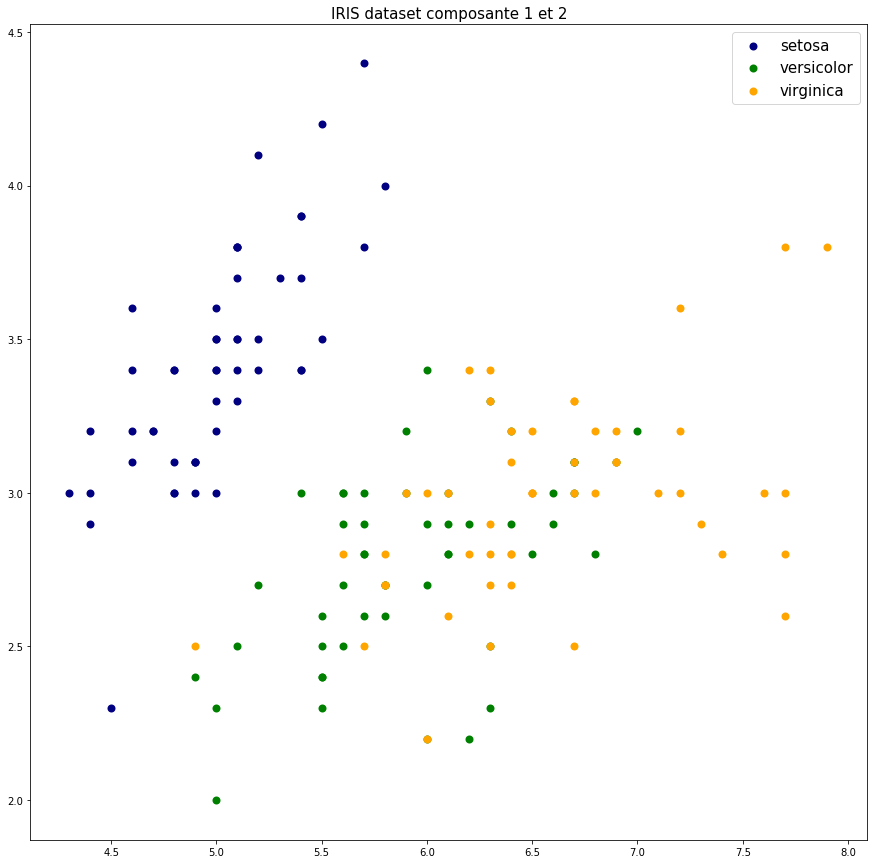

In [3]:
plt.figure(figsize=(15,15))
colors = ['navy', 'green', 'orange']
lw = 2
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(Xreduced[y == i, 0], Xreduced[y == i, 1], color=color, lw=lw,label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1,fontsize=15)
plt.title('IRIS dataset composante 1 et 2',fontsize=15)
plt.show()

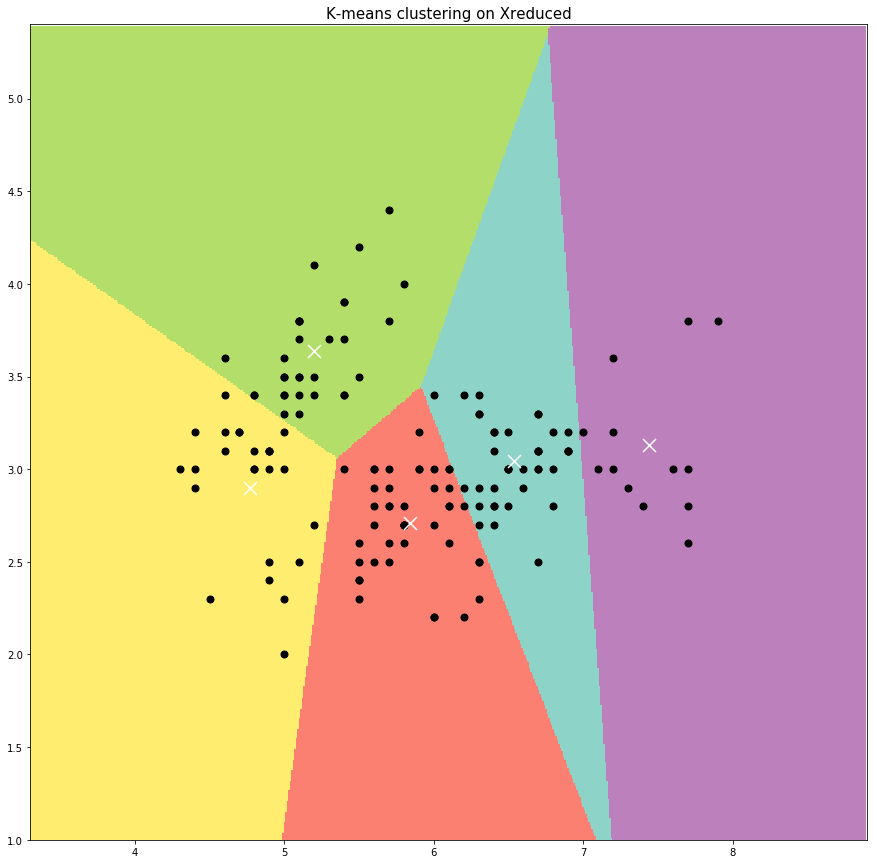

In [4]:
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
kmeans.fit(Xreduced)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = Xreduced[:, 0].min() - 1, Xreduced[:, 0].max() + 1
y_min, y_max = Xreduced[:, 1].min() - 1, Xreduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(15,15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Set3,
           aspect='auto', origin='lower')

plt.plot(Xreduced[:, 0], Xreduced[:, 1], 'ko', markersize=7)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=5,
            color='w', zorder=10)
plt.title('K-means clustering on Xreduced',fontsize=15)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
#plt.xticks(())
#plt.yticks(())
plt.show()


In [5]:
def mutual_distances(X):
    D=np.zeros((X.shape[0],X.shape[0]))
    for i in range(len(X)):
        for j in range(i,len(X)):
            D[i,j]=np.sum((X[i]-X[j])**2)
    return D

In [93]:
class OutliersKmeans:
    ''' v.0.1 OutliersKmeans : Find outliers using Kmeans. Only for semi-supervised outlier detection'''
    def __init__(self,normaldata,kmeans):   
        self.normaldata=normaldata
        self.kmeans=kmeans
        
    def sleep(self,delay):
        if __name__ != '__main__':
            delay /= non_interactive_sleep_factor
        time.sleep(delay)
        
    
    def to_center_distances(self,X,mu):
        D=[]
        for i in range(len(X)):
            D.append(np.sum((X[i]-mu)**2))
        return D
        
    def find_extreme_point(self,centers,ypred,X):
        K=len(centers)
        d={}
        for i in range(K):    
            X_in_cluster=X[np.where(ypred==i),:][0]
            D=self.to_center_distances(X_in_cluster,centers[i])
            indexmax=np.argmax(D)
            d[i+1]=(X[indexmax],math.sqrt(np.max(D)))
        return d

    def draw_circle(self,Npoints,radius,center):
        circle_slice=2*math.pi/Npoints
        p=[]
        for i in range(Npoints):
            angle=circle_slice*i
            newx=center[0]+radius*math.cos(angle)
            newy=center[1]+radius*math.sin(angle)
            p.append([newx,newy])
        return np.array(p)
        
    def bounds(self,centers,ypred,Xreduced,Npoints=100):
        d=self.find_extreme_point(centers,ypred,Xreduced)
        K=len(d)
        circles=[]
        for i in range(K):
            center=centers[i]
            radius=d[i+1][1]
            circles.append(self.draw_circle(Npoints,radius,center))
        return circles
    
    def in_circle(self,point,center,radius):
        return math.sqrt(np.sum((point-center)**2))<=radius 
    
    def in_any_circle(self,point,centers,d):
        K=len(d)
        incirclek=[]    
        for k in range(K):
            center=centers[k]
            radius=d[k+1][1]
            incirclek.append(self.in_circle(point,center,radius))
        return np.any(incirclek)
        
    def is_outlier(self,points,showbar=True):
        self.kmeans.fit(self.normaldata)
        y=self.kmeans.predict(self.normaldata)
        centers=self.kmeans.cluster_centers_
        d=self.find_extreme_point(centers,y,self.normaldata)
        result=[]
        if showbar == True :
            widgets = [progressbar.Percentage(), progressbar.Bar()]
            bar = progressbar.ProgressBar(widgets=widgets, max_value=len(points)).start()
            j=0

        for point in points:  

            result.append(not(self.in_any_circle(point,centers,d)))

            if showbar== True :
                self.sleep(0.1)
                bar.update(j)
                j=j+1

        if showbar== True :
            bar.finish()
        return result        

In [94]:
Xreduced=X[:,0:2]
K=5
kmeans = KMeans(init='k-means++', n_clusters=K, n_init=10,random_state=5)
outliers=[]
outliers.append([8,5])
outliers.append([4,1.5])
outliers.append([6,3])
outliers.append([5,2.5])
outliers.append([7,1.5])
outlierKmeans=OutliersKmeans(normaldata=Xreduced,kmeans=kmeans)

In [95]:
outlierKmeans.is_outlier(outliers)

100%|#########################################################################|


[True, True, False, False, True]

In [9]:
def f(x):
     return x*x

In [15]:
def g(liste):
    return outlierKmeans.is_outlier(liste)

In [16]:
p = Pool(4)

In [17]:
p.map(f, range(10))

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [18]:
p.map(g, outliers)

NameError: name 'outlierKmeans' is not defined

100%|#########################################################################|


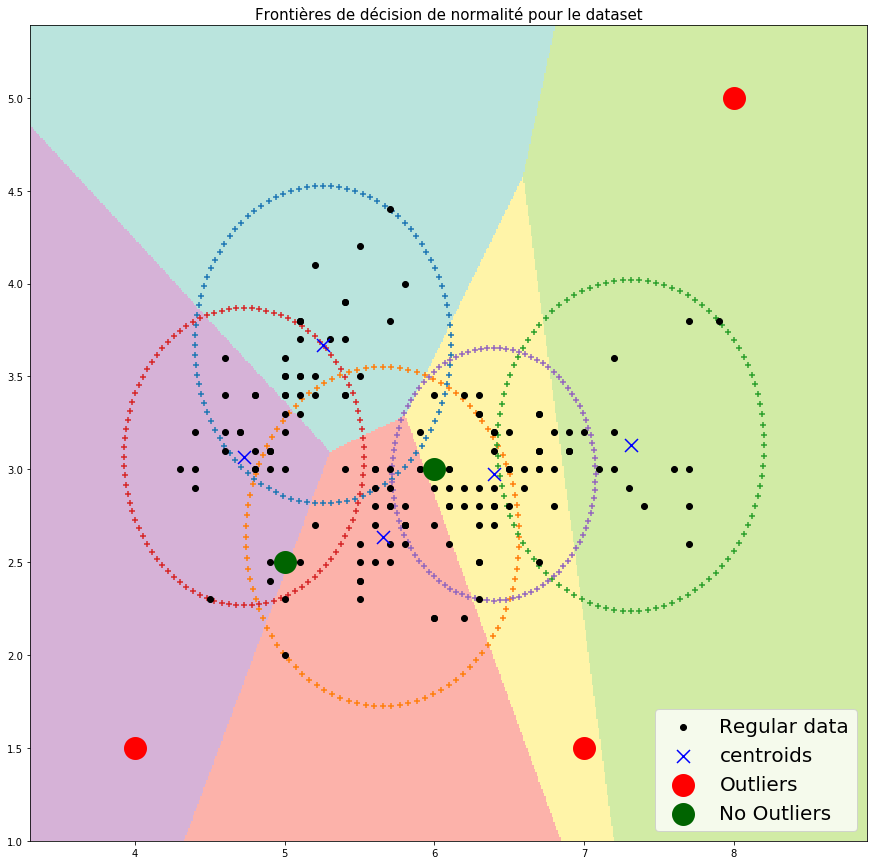

In [96]:
outliers=[]
outliers.append([8,5])
outliers.append([4,1.5])
outliers.append([6,3])
outliers.append([5,2.5])
outliers.append([7,1.5])
outliers=np.array(outliers)
Xreduced=X[:,0:2]
K=5
kmeans = KMeans(init='k-means++', n_clusters=K, n_init=10,random_state=5)
kmeans.fit(Xreduced)
y=kmeans.predict(Xreduced)
centers=kmeans.cluster_centers_
indicesoutliers=outlierKmeans.is_outlier(outliers)

fig=plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1)
A=outlierKmeans.bounds(centers,y,Xreduced)
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = Xreduced[:, 0].min() - 1, Xreduced[:, 0].max() + 1
y_min, y_max = Xreduced[:, 1].min() - 1, Xreduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation='nearest',extent=(xx.min(), xx.max(), yy.min(), yy.max()),cmap=plt.cm.Set3,aspect='auto', origin='lower', alpha=0.6)
for circle in A:
    plt.scatter(circle[:,0],circle[:,1],marker='+',linewidths=5)
p1=plt.scatter(Xreduced[:, 0], Xreduced[:, 1], color='k',marker='o')
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
p2=plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=5,
            color='blue', zorder=10)
# Plot the outliers 
p3=plt.scatter(outliers[indicesoutliers, 0], outliers[indicesoutliers, 1], s=169, linewidths=10,
            color='red', zorder=10)
# Plot the non outliers 
p4=plt.scatter(outliers[~np.array(indicesoutliers), 0], outliers[~np.array(indicesoutliers), 1], s=169, linewidths=10,
            color='darkgreen', zorder=10)
ax.legend([p1,p2,p3,p4], ["Regular data","centroids", "Outliers","No Outliers"],fontsize=20,loc=4)
plt.title('Frontières de décision de normalité pour le dataset',fontsize=15)
plt.show()

## On desicionnel

In [23]:
path_images = 'D:\\Users\\S37283\\Documents\\Outlier detection'
header=['idcli_horus', 'topCSPplus', 'revenu', 'gold', 'topstpub', 'top_in', 'top_out', 'prodres_T1', 'prodamo_T1', 'prod_T1', 'top_port', 'top_fixe', 'emailvalide', 'validemail', 'ancclient', 'derprod_arch', 'cli_actif', 'cli_inactif', 'top_homme', 'top_femme', 'habit_prop', 'habit_loc', 'habit_aut', 'csp_actif', 'csp_inact', 'csp_sup', 'csp_ret', 'csp_emp', 'csp_ouv', 'csp_resp', 'sitfam_C', 'sitfam_M', 'sitfam_D', 'sitfam_U', 'sitfam_V', 'sitfam_S', 'sitfam_DS', 'sitfam_DSV', 'sitfam_MU', 'agiopb12m', 'agiovac12m', 'agiorccc12m', 'agiorccl12m', 'agiopb6m', 'agiovac6m', 'agiorccc6m', 'agiorccl6m', 'encpb_m1', 'encvac_m1', 'encrccc_m1', 'encrccl_m1', 'encleas_m1', 'disporccl_m1', 'encpb_m2', 'encvac_m2', 'encrccc_m2', 'encrccl_m2', 'encleas_m2', 'disporccc_m2', 'disporccl_m2', 'encpb_m3', 'encvac_m3', 'encrccc_m3', 'encrccl_m3', 'encleas_m3', 'disporccc_m3', 'disporccl_m3', 'encpb_m4', 'encvac_m4', 'encrccc_m4', 'encrccl_m4', 'encleas_m4', 'disporccc_m4', 'disporccl_m4', 'encpb_m5', 'encvac_m5', 'encrccc_m5', 'encrccl_m5', 'encleas_m5', 'disporccc_m5', 'disporccl_m5', 'encpb_m6', 'encvac_m6', 'encrccc_m6', 'encrccl_m6', 'encleas_m6', 'disporccc_m6', 'disporccl_m6', 'encpb_m7', 'encvac_m7', 'encrccc_m7', 'encrccl_m7', 'encleas_m7', 'disporccc_m7', 'disporccl_m7', 'encpb_m8', 'encvac_m8', 'encrccc_m8', 'encrccl_m8', 'encleas_m8', 'disporccc_m8', 'disporccl_m8', 'encpb_m9', 'encvac_m9', 'encrccc_m9', 'encrccl_m9', 'encleas_m9', 'disporccc_m9', 'disporccl_m9', 'encpb_m10', 'encvac_m10', 'encrccc_m10', 'encrccl_m10', 'encleas_m10', 'disporccc_m10', 'disporccl_m10', 'encpb_m11', 'encvac_m11', 'encrccc_m11', 'encrccl_m11', 'encleas_m11', 'disporccc_m11', 'disporccl_m11', 'encpb_m12', 'encvac_m12', 'encrccc_m12', 'encrccl_m12', 'encleas_m12', 'disporccc_m12', 'disporccl_m12', 'agio12m', 'agio6m', 'agioamo12m', 'agioamo6m', 'agiores12m', 'agiores6m', 'enc_m1', 'encamo_m1', 'encres_m1', 'dispo_m1', 'enc_m2', 'encamo_m2', 'encres_m2', 'dispo_m2', 'enc_m3', 'encamo_m3', 'encres_m3', 'dispo_m3', 'enc_m4', 'encamo_m4', 'encres_m4', 'dispo_m4', 'enc_m5', 'encamo_m5', 'encres_m5', 'dispo_m5', 'enc_m6', 'encamo_m6', 'encres_m6', 'dispo_m6', 'enc_m7', 'encamo_m7', 'encres_m7', 'dispo_m7', 'enc_m8', 'encamo_m8', 'encres_m8', 'dispo_m8', 'enc_m9', 'encamo_m9', 'encres_m9', 'dispo_m9', 'enc_m10', 'encamo_m10', 'encres_m10', 'dispo_m10', 'enc_m11', 'encamo_m11', 'encres_m11', 'dispo_m11', 'enc_m12', 'encamo_m12', 'encres_m12', 'dispo_m12', 'nbmenc12M', 'nbmenc6M', 'nbmencamo12M', 'nbmencamo6M', 'nbmencres12M', 'nbmencres6M', 'nbmdispo12M', 'nbmdispo6M', 'senc12M', 'senc6M', 'sencamo12M', 'sencamo6M', 'sencpb12M', 'sencpb6M', 'sencvac12M', 'sencvac6M', 'sencres12M', 'sencres6M', 'sencrccc12M', 'sencrccc6M', 'sencrccl12M', 'sencrccl6M', 'sdispo12M', 'sdispo6M', 'sdisporccc12M', 'sdisporccc6M', 'sdisporccl12M', 'sdisporccl6M', 'moyenc12M', 'moyencamo12M', 'moyencpb12M', 'moyencvac12M', 'moyencres12M', 'moyencrccc12M', 'moyencrccl12M', 'moydispo12M', 'moydisporccc12M', 'moydisporccl12M', 'moyenc6M', 'moyencamo6M', 'moyencpb6M', 'moyencvac6M', 'moyencres6M', 'moyencrccc6M', 'moyencrccl6M', 'moydispo6M', 'moydisporccc6M', 'moydisporccl6M', 'agiopb_m1', 'agiovac_m1', 'agiorccc_m1', 'agiorccl_m1', 'agiopb_m2', 'agiovac_m2', 'agiorccc_m2', 'agiorccl_m2', 'agiopb_m3', 'agiovac_m3', 'agiorccc_m3', 'agiorccl_m3', 'agiopb_m4', 'agiovac_m4', 'agiorccc_m4', 'agiorccl_m4', 'agiopb_m5', 'agiovac_m5', 'agiorccc_m5', 'agiorccl_m5', 'agiopb_m6', 'agiovac_m6', 'agiorccc_m6', 'agiorccl_m6', 'agiopb_m7', 'agiovac_m7', 'agiorccc_m7', 'agiorccl_m7', 'agiopb_m8', 'agiovac_m8', 'agiorccc_m8', 'agiorccl_m8', 'agiopb_m9', 'agiovac_m9', 'agiorccc_m9', 'agiorccl_m9', 'agiopb_m10', 'agiovac_m10', 'agiorccc_m10', 'agiorccl_m10', 'agiopb_m11', 'agiovac_m11', 'agiorccc_m11', 'agiorccl_m11', 'agiopb_m12', 'agiovac_m12', 'agiorccc_m12', 'agiorccl_m12', 'agio_m1', 'agioamo_m1', 'agiores_m1', 'agio_m2', 'agioamo_m2', 'agiores_m2', 'agio_m3', 'agioamo_m3', 'agiores_m3', 'agio_m4', 'agioamo_m4', 'agiores_m4', 'agio_m5', 'agioamo_m5', 'agiores_m5', 'agio_m6', 'agioamo_m6', 'agiores_m6', 'agio_m7', 'agioamo_m7', 'agiores_m7', 'agio_m8', 'agioamo_m8', 'agiores_m8', 'agio_m9', 'agioamo_m9', 'agiores_m9', 'agio_m10', 'agioamo_m10', 'agiores_m10', 'agio_m11', 'agioamo_m11', 'agiores_m11', 'agio_m12', 'agioamo_m12', 'agiores_m12', 'nbmagio12M', 'nbmagio6M', 'nbmagioamo12M', 'nbmagioamo6M', 'nbmagiores12M', 'nbmagiores6M', 'minagio6M', 'minagio12M', 'maxagio6M', 'maxagio12M', 'minagiopb6M', 'minagiopb12M', 'maxagiopb6M', 'maxagiopb12M', 'minagiovac6M', 'minagiovac12M', 'maxagiovac6M', 'maxagiovac12M', 'minagiorccc6M', 'minagiorccc12M', 'maxagiorccc6M', 'maxagiorccc12M', 'minagiorccl6M', 'minagiorccl12M', 'maxagiorccl6M', 'maxagiorccl12M', 'minagioamo6M', 'minagioamo12M', 'maxagioamo6M', 'maxagioamo12M', 'minagiores6M', 'minagiores12M', 'maxagiores6M', 'maxagiores12M', 'minenc6M', 'minenc12M', 'maxenc6M', 'maxenc12M', 'minencpb6M', 'minencpb12M', 'maxencpb6M', 'maxencpb12M', 'minencvac6M', 'minencvac12M', 'maxencvac6M', 'maxencvac12M', 'minencrccc6M', 'minencrccc12M', 'maxencrccc6M', 'maxencrccc12M', 'minencrccl6M', 'minencrccl12M', 'maxencrccl6M', 'maxencrccl12M', 'minencamo6M', 'minencamo12M', 'maxencamo6M', 'maxencamo12M', 'minencres6M', 'minencres12M', 'maxencres6M', 'maxencres12M', 'mindispo6M', 'mindispo12M', 'maxdispo6M', 'maxdispo12M', 'maxdisporccc6M', 'maxdisporccc12M', 'mindisporccl6M', 'mindisporccl12M', 'maxdisporccl6M', 'maxdisporccl12M', 'nbpb', 'nbvac', 'nbleas', 'nbrccc', 'nbrccl', 'nbpbarc', 'nbvacarc', 'nbleasarc', 'nbrcccarc', 'nbrcclarc', 'nbpbnarc', 'nbvacnarc', 'nbleasnarc', 'nbrcccnarc', 'nbrcclnarc', 'toppb', 'topvac', 'topleas', 'toprccc', 'toppbarc', 'topvacarc', 'topleasarc', 'toprcccarc', 'toprcclarc', 'toppbnarc', 'topvacnarc', 'topleasnarc', 'toprcccnarc', 'toprcclnarc', 'nbdemat', 'nbdematarc', 'nbdematnarc', 'topdemat', 'topdematarc', 'topdematnarc', 'nbcpthl', 'nbcptl', 'nbamo', 'nbres', 'nbcpthlarc', 'nbcptlarc', 'nbamoarc', 'nbresarc', 'nbcpthlnarc', 'nbcptlnarc', 'nbamonarc', 'nbresnarc', 'topamo', 'topamoarc', 'topresarc', 'topamonarc', 'topresnarc', 'mtpb', 'mtvac', 'mtrccc', 'mtrccl', 'mtpbarc', 'mtvacarc', 'mtrcccarc', 'mtrcclarc', 'mtpbnarc', 'mtvacnarc', 'mtrcccnarc', 'mtrcclnarc', 'mtamo', 'mtres', 'mtamoarc', 'mtresarc', 'mtamonarc', 'mtresnarc', 'mtminpb', 'mtminvac', 'mtminrccc', 'mtminrccl', 'mtmaxpb', 'mtmaxvac', 'mtmaxrccc', 'mtmaxrccl', 'mtminamo', 'mtminres', 'mtmaxamo', 'mtmaxres', 'recderpb', 'recdervac', 'recderrccc', 'recderrccl', 'recdarcpb', 'recdarcvac', 'recdarcrccc', 'recdarcrccl', 'recdercpt', 'recderamo', 'recderres', 'recdarccpt', 'recdarcamo', 'recdarcres', 'nbsoll_m1', 'nbsmail_m1', 'nbsemail_m1', 'nbsas_m1', 'nbsanim_m1', 'nbscross_m1', 'nbsoll_m2', 'nbsmail_m2', 'nbsemail_m2', 'nbsas_m2', 'nbsanim_m2', 'nbscross_m2', 'nbsoll_m3', 'nbsmail_m3', 'nbsemail_m3', 'nbsas_m3', 'nbsanim_m3', 'nbscross_m3', 'nbsoll_m4', 'nbsmail_m4', 'nbsemail_m4', 'nbsas_m4', 'nbsanim_m4', 'nbscross_m4', 'nbsoll_m5', 'nbsmail_m5', 'nbsemail_m5', 'nbsas_m5', 'nbsanim_m5', 'nbscross_m5', 'nbsoll_m6', 'nbsmail_m6', 'nbsemail_m6', 'nbsas_m6', 'nbsanim_m6', 'nbscross_m6', 'nbsoll_m7', 'nbsmail_m7', 'nbsemail_m7', 'nbsas_m7', 'nbsanim_m7', 'nbscross_m7', 'nbsoll_m8', 'nbsmail_m8', 'nbsemail_m8', 'nbsas_m8', 'nbsanim_m8', 'nbscross_m8', 'nbsoll_m9', 'nbsmail_m9', 'nbsemail_m9', 'nbsas_m9', 'nbsanim_m9', 'nbscross_m9', 'nbsoll_m10', 'nbsmail_m10', 'nbsemail_m10', 'nbsas_m10', 'nbsanim_m10', 'nbscross_m10', 'nbsoll_m11', 'nbsmail_m11', 'nbsemail_m11', 'nbsas_m11', 'nbsanim_m11', 'nbscross_m11', 'nbmsoll12M', 'nbmsoll6M', 'nbmsoll3M', 'nbmsmail12M', 'nbmsmail6M', 'nbmsmail3M', 'nbmsemail12M', 'nbmsemail6M', 'nbmsemail3M', 'nbmssms12M', 'nbmssms6M', 'nbmssms3M', 'nbmsas12M', 'nbmsas6M', 'nbmsas3M', 'nbmsanim12M', 'nbmsanim6M', 'nbmsanim3M', 'nbmscross12M', 'nbmscross6M', 'nbmscross3M', 'nbsoll3M', 'nbsoll6M', 'nbsoll12M', 'nbsanim3M', 'nbsanim6M', 'nbsanim12M', 'nbscross3M', 'nbscross6M', 'nbscross12M', 'nbsmail3M', 'nbsmail6M', 'nbsmail12M', 'nbsemail3M', 'nbsemail6M', 'nbsemail12M', 'nbssms3M', 'nbssms6M', 'nbssms12M', 'nbsas3M', 'nbsas6M', 'nbsas12M', 'maxnbsoll3M', 'maxnbsoll6M', 'maxnbsoll12M', 'minnbsoll3M', 'minnbsoll6M', 'maxnbsanim3M', 'maxnbsanim6M', 'maxnbsanim12M', 'minnbsanim3M', 'minnbsanim6M', 'maxnbscross3M', 'maxnbscross6M', 'maxnbscross12M', 'minnbscross3M', 'minnbscross6M', 'maxnbsmail3M', 'maxnbsmail6M', 'maxnbsmail12M', 'minnbsmail3M', 'minnbsmail6M', 'maxnbsemail3M', 'maxnbsemail6M', 'maxnbsemail12M', 'minnbsemail3M', 'minnbsemail6M', 'nbae_m1', 'nbaeds_m1', 'nbaems_m1', 'nbaefs_m1', 'nbaeam_m1', 'nbaepm_m1', 'nbae_m2', 'nbaeds_m2', 'nbaems_m2', 'nbaefs_m2', 'nbaeam_m2', 'nbaepm_m2', 'nbae_m3', 'nbaeds_m3', 'nbaems_m3', 'nbaefs_m3', 'nbaeam_m3', 'nbaepm_m3', 'nbae_m4', 'nbaeds_m4', 'nbaems_m4', 'nbaefs_m4', 'nbaeam_m4', 'nbaepm_m4', 'nbae_m5', 'nbaeds_m5', 'nbaems_m5', 'nbaefs_m5', 'nbaeam_m5', 'nbaepm_m5', 'nbae_m6', 'nbaeds_m6', 'nbaems_m6', 'nbaefs_m6', 'nbaeam_m6', 'nbaepm_m6', 'nbae_m7', 'nbaeds_m7', 'nbaems_m7', 'nbaefs_m7', 'nbaeam_m7', 'nbaepm_m7', 'nbae_m8', 'nbaeds_m8', 'nbaems_m8', 'nbaefs_m8', 'nbaeam_m8', 'nbaepm_m8', 'nbae_m9', 'nbaeds_m9', 'nbaems_m9', 'nbaefs_m9', 'nbaeam_m9', 'nbaepm_m9', 'nbae_m10', 'nbaeds_m10', 'nbaems_m10', 'nbaefs_m10', 'nbaeam_m10', 'nbaepm_m10', 'nbae_m11', 'nbaeds_m11', 'nbaems_m11', 'nbaefs_m11', 'nbaeam_m11', 'nbaepm_m11', 'nbae_m12', 'nbaeds_m12', 'nbaems_m12', 'nbaefs_m12', 'nbaeam_m12', 'nbaepm_m12', 'nbmae12M', 'nbmae6M', 'nbmae3M', 'nbmaeds12M', 'nbmaeds6M', 'nbmaeds3M', 'nbmaems12M', 'nbmaems6M', 'nbmaems3M', 'nbmaefs12M', 'nbmaefs6M', 'nbmaefs3M', 'nbmaeam12M', 'nbmaeam6M', 'nbmaeam3M', 'nbmaepm12M', 'nbmaepm6M', 'nbmaepm3M', 'nbae3M', 'nbae6M', 'nbae12M', 'maxnbae3M', 'maxnbae6M', 'maxnbae12M', 'nbaeds3M', 'nbaeds6M', 'nbaeds12M', 'maxnbaeds3M', 'maxnbaeds6M', 'maxnbaeds12M', 'nbaems3M', 'nbaems6M', 'nbaems12M', 'maxnbaems3M', 'maxnbaems6M', 'maxnbaems12M', 'nbaefs3M', 'nbaefs6M', 'nbaefs12M', 'maxnbaefs3M', 'maxnbaefs6M', 'maxnbaefs12M', 'nbaeam3M', 'nbaeam6M', 'nbaeam12M', 'maxnbaeam3M', 'maxnbaeam6M', 'maxnbaeam12M', 'nbaepm3M', 'nbaepm6M', 'nbaepm12M', 'maxnbaepm3M', 'maxnbaepm6M', 'maxnbaepm12M', 'topA3', 'topB4', 'topB5', 'topF5', 'topF6', 'topM2', 'prodmagrccl_m1', 'prodtresrccl_m1', 'prodcartrccl_m1', 'prodmagres_m1', 'prodtresres_m1', 'prodcartres_m1', 'prodrccl_m1', 'prodres_m1', 'prodmagrccl_m2', 'prodtresrccc_m2', 'prodtresrccl_m2', 'prodcartrccl_m2', 'prodmagres_m2', 'prodtresres_m2', 'prodcartres_m2', 'prodrccc_m2', 'prodrccl_m2', 'prodres_m2', 'prodmagrccc_m3', 'prodmagrccl_m3', 'prodtresrccc_m3', 'prodtresrccl_m3', 'prodcartrccl_m3', 'prodmagres_m3', 'prodtresres_m3', 'prodcartres_m3', 'prodrccc_m3', 'prodrccl_m3', 'prodres_m3', 'prodmagrccl_m4', 'prodtresrccc_m4', 'prodtresrccl_m4', 'prodcartrccl_m4', 'prodmagres_m4', 'prodtresres_m4', 'prodcartres_m4', 'prodrccc_m4', 'prodrccl_m4', 'prodres_m4', 'prodmagrccl_m5', 'prodtresrccc_m5', 'prodtresrccl_m5', 'prodcartrccl_m5', 'prodmagres_m5', 'prodtresres_m5', 'prodcartres_m5', 'prodrccc_m5', 'prodrccl_m5', 'prodres_m5', 'prodmagrccl_m6', 'prodtresrccc_m6', 'prodtresrccl_m6', 'prodcartrccc_m6', 'prodcartrccl_m6', 'prodmagres_m6', 'prodtresres_m6', 'prodcartres_m6', 'prodrccc_m6', 'prodrccl_m6', 'prodres_m6', 'prodmagrccl_m7', 'prodtresrccc_m7', 'prodtresrccl_m7', 'prodcartrccc_m7', 'prodcartrccl_m7', 'prodmagres_m7', 'prodtresres_m7', 'prodcartres_m7', 'prodrccc_m7', 'prodrccl_m7', 'prodres_m7', 'prodmagrccl_m8', 'prodtresrccc_m8', 'prodtresrccl_m8', 'prodcartrccc_m8', 'prodcartrccl_m8', 'prodmagres_m8', 'prodtresres_m8', 'prodcartres_m8', 'prodrccc_m8', 'prodrccl_m8', 'prodres_m8', 'prodmagrccl_m9', 'prodtresrccc_m9', 'prodtresrccl_m9', 'prodcartrccc_m9', 'prodcartrccl_m9', 'prodmagres_m9', 'prodtresres_m9', 'prodcartres_m9', 'prodrccc_m9', 'prodrccl_m9', 'prodres_m9', 'prodmagrccl_m10', 'prodtresrccc_m10', 'prodtresrccl_m10', 'prodcartrccc_m10', 'prodcartrccl_m10', 'prodmagres_m10', 'prodtresres_m10', 'prodcartres_m10', 'prodrccc_m10', 'prodrccl_m10', 'prodres_m10', 'prodmagrccl_m11', 'prodtresrccc_m11', 'prodtresrccl_m11', 'prodcartrccc_m11', 'prodcartrccl_m11', 'prodmagres_m11', 'prodtresres_m11', 'prodcartres_m11', 'prodrccc_m11', 'prodrccl_m11', 'prodres_m11', 'prodmagrccc_m12', 'prodmagrccl_m12', 'prodtresrccc_m12', 'prodtresrccl_m12', 'prodcartrccc_m12', 'prodcartrccl_m12', 'prodmagres_m12', 'prodtresres_m12', 'prodcartres_m12', 'prodrccc_m12', 'prodrccl_m12', 'prodres_m12', 'nbmpres12M', 'nbmpres6M', 'nbmprccc12M', 'nbmprccc6M', 'nbmprccl12M', 'nbmprccl6M', 'nbmpmagres12M', 'nbmpmagres6M', 'nbmptresres12M', 'nbmptresres6M', 'nbmpcartres12M', 'nbmpcartres6M', 'nbmpmagrccc12M', 'nbmpmagrccc6M', 'nbmptresrccc12M', 'nbmptresrccc6M', 'nbmpcartrccc12M', 'nbmpcartrccc6M', 'nbmpmagrccl12M', 'nbmpmagrccl6M', 'nbmptresrccl12M', 'nbmptresrccl6M', 'nbmpcartrccl12M', 'nbmpcartrccl6M', 'spres12M', 'spres6M', 'sprccc12M', 'sprccc6M', 'sprccl12M', 'sprccl6M', 'spmagres12M', 'spmagres6M', 'sptresres12M', 'sptresres6M', 'spcartres12M', 'spcartres6M', 'spmagrccc12M', 'spmagrccc6M', 'sptresrccc12M', 'sptresrccc6M', 'spcartrccc12M', 'spcartrccc6M', 'spmagrccl12M', 'spmagrccl6M', 'sptresrccl12M', 'sptresrccl6M', 'spcartrccl12M', 'spcartrccl6M', 'minprodres6M', 'minprodres12M', 'maxprodres6M', 'maxprodres12M', 'maxprodrccc6M', 'maxprodrccc12M', 'minprodrccl6M', 'minprodrccl12M', 'maxprodrccl6M', 'maxprodrccl12M', 'minprodmagres6M', 'minprodmagres12M', 'maxprodmagres6M', 'maxprodmagres12M', 'maxprodmagrccc6M', 'maxprodmagrccc12M', 'minprodmagrccl6M', 'minprodmagrccl12M', 'maxprodmagrccl6M', 'maxprodmagrccl12M', 'minprodtresres6M', 'minprodtresres12M', 'maxprodtresres6M', 'maxprodtresres12M', 'maxprodtresrccc6M', 'maxprodtresrccc12M', 'minprodtresrccl6M', 'minprodtresrccl12M', 'maxprodtresrccl6M', 'maxprodtresrccl12M', 'minprodcartres6M', 'minprodcartres12M', 'maxprodcartres6M', 'maxprodcartres12M', 'maxprodcartrccc6M', 'maxprodcartrccc12M', 'minprodcartrccl6M', 'minprodcartrccl12M', 'maxprodcartrccl6M', 'maxprodcartrccl12M', 'actif', 'arch1an', 'arch3an', 'arch5an', 'nbckg', 'ckg_actif', 'ckg_1an', 'ckg_anim', 'ckg_3an', 'ckg_5an', 'nbptps', 'ptps_actif', 'ptps_1an', 'ptps_anim', 'ptps_3an', 'ptps_5an', 'nbfnac', 'fnac_actif', 'fnac_1an', 'fnac_anim', 'fnac_3an', 'fnac_5an', 'nblfnac', 'fnac', 'nbrcem', 'rcem_actif', 'rcem_1an', 'rcem_anim', 'rcem_3an', 'rcem_5an', 'nbCC', 'CC_3an', 'CC_5an', 'a_cfpe', 'a_cfp', 'a_cfe', 'a_cpe', 'a_fpe', 'a_cf', 'a_cp', 'a_ce', 'a_fp', 'a_fe', 'a_pe', 'a_c', 'a_f', 'a_p', 'a_e', 'fin']
path='D:\\Users\\S37283\\Desktop\\dtm_cross201606.csv.gz'

In [24]:
store_cible=pd.HDFStore('D:\\Users\\S37283\\Documents\\Python_Scripts\\cible_crossB2B.h5')

In [25]:
dfCible=store_cible.select('dfCible')
indices1=np.where(dfCible['fin']==1)[0]

In [26]:
n = 2572345 #number of records in file
s = 200000 #desired sample size
skip = sorted(random.sample(range(n),n-s))

In [27]:
skip2=list(set(range(n)).difference(indices1))
skip3=[x+1 for x in skip2]

In [28]:
df_sample = pd.read_table(path,compression='gzip', sep=';',lineterminator='\n',skiprows=skip)
df_sample2 = pd.read_table(path,compression='gzip', sep=';',lineterminator='\n',skiprows=skip3)
df_sample2.columns=header
df_sample.columns=header

In [29]:
frames= [df_sample,df_sample2]
df= pd.concat(frames)

In [30]:
del df_sample
del df_sample2

In [31]:
df.head()

,idcli_horus,topCSPplus,revenu,gold,topstpub,top_in,top_out,prodres_T1,prodamo_T1,prod_T1,...,a_cp,a_ce,a_fp,a_fe,a_pe,a_c,a_f,a_p,a_e,fin
0,91000100524,0,2700.0,0,0,0,0,480.27,0.0,480.27,...,0,0,0,0,0,0,0,0,1,0
1,91000131078,0,1500.0,0,1,1,0,495.00,0.0,495.00,...,0,0,0,0,0,0,0,0,1,0
2,91000278993,0,2200.0,0,1,0,0,0.00,0.0,0.00,...,0,0,0,0,0,0,0,0,1,0
3,91000395739,1,15000.0,0,0,0,0,0.00,0.0,0.00,...,0,0,0,0,0,0,0,1,0,0
4,91000504639,0,4200.0,0,0,0,0,201.37,0.0,201.37,...,0,0,0,0,0,1,0,0,0,0


On va considérer que les "bons clients" ou les clients qui ont des données "normales" sont d'abord ceux qui ont fait un financement (ça sous entend qu'ils ont les bonnes données). On va aussi prendre les clients qui ont déclaré un revenu.

In [32]:
df=df.fillna(0)

In [112]:
df=pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df),columns=df.columns)
df=df.drop('idcli_horus',axis=1)

In [113]:
normal_dataset= np.array(df.loc[(df['fin']==1)|(df['revenu']>0)])
test_dataset=np.array(df.loc[~df.index.isin(df.loc[(df['fin']==1)|(df['revenu']>0)].index)].sample(frac=0.1))

In [114]:
K=5
kmeans = KMeans(init='k-means++', n_clusters=K, n_init=10,random_state=5)
outlierKmeans=OutliersKmeans(normaldata=normal_dataset,kmeans=kmeans)

In [117]:
tests=outlierKmeans.is_outlier(test_dataset)

100%|#########################################################################|


In [118]:
len(np.where(np.array(tests)==True)[0])/len(tests)

0.0

Ok ils sont tous normaux..

### With dimension reduction PCA (for visualisation)

In [33]:
from sklearn.decomposition import PCA

In [34]:
DF=pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df),columns=df.columns)
DF=DF.drop('idcli_horus',axis=1)

In [35]:
pca=PCA(n_components=20,svd_solver='arpack')
pca.fit(DF)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='arpack', tol=0.0, whiten=False)

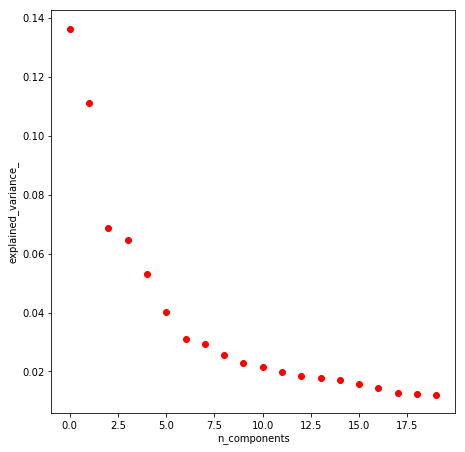

In [36]:
plt.figure(1, figsize=(8, 8))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_,'ro', linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

In [37]:
pca=PCA(n_components=2,svd_solver='arpack')
pca.fit(DF)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='arpack', tol=0.0, whiten=False)

In [100]:
normal_dataset=DF.loc[(DF['fin']==1)|(DF['revenu']>0)]
test_dataset=DF.loc[~DF.index.isin(DF.loc[(DF['fin']==1)|(DF['revenu']>0)].index)].sample(n=500)

In [107]:
normal_dataset=DF.loc[(DF['fin']==1)]
test_dataset=DF.loc[~DF.index.isin(DF.loc[(DF['fin']==1)])].sample(n=500)

In [108]:
normal_dataset_proj=pca.transform(normal_dataset)
test_dataset_proj=pca.transform(test_dataset)

In [109]:
K=5
kmeans = KMeans(init='k-means++', n_clusters=K, n_init=10,random_state=5)
outlierKmeans=OutliersKmeans(normaldata=normal_dataset_proj,kmeans=kmeans)

In [110]:
kmeans.fit(normal_dataset_proj)
y=kmeans.predict(normal_dataset_proj)
centers=kmeans.cluster_centers_
indicesoutliers=outlierKmeans.is_outlier(test_dataset_proj)

100%|#########################################################################|


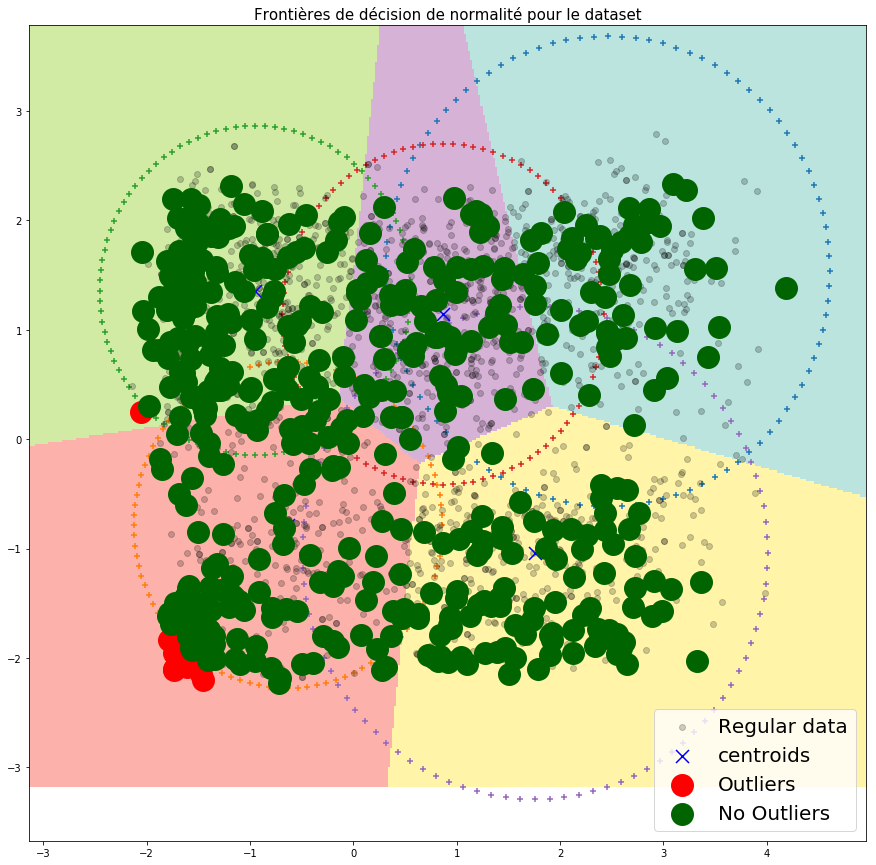

In [111]:
fig=plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1)
A=outlierKmeans.bounds(centers,y,normal_dataset_proj)
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].
L=1
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = normal_dataset_proj[:, 0].min() - L, normal_dataset_proj[:, 0].max() + L
y_min, y_max = normal_dataset_proj[:, 1].min() - L, normal_dataset_proj[:, 1].max() + L
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation='nearest',extent=(xx.min(), xx.max(), yy.min(), yy.max()),cmap=plt.cm.Set3,aspect='auto', origin='lower', alpha=0.6)
for circle in A:
    plt.scatter(circle[:,0],circle[:,1],marker='+',linewidths=5)
# Plot the regular dataset
p1=plt.scatter(normal_dataset_proj[:, 0], normal_dataset_proj[:, 1], color='k',marker='o',alpha=0.2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
p2=plt.scatter(centroids[:, 0], centroids[:, 1],marker='x', s=169, linewidths=5,color='blue', zorder=10)
# Plot the outliers 
p3=plt.scatter(test_dataset_proj[indicesoutliers, 0], test_dataset_proj[indicesoutliers, 1], s=169, linewidths=10,
            color='red', zorder=10)
# Plot the non outliers 
p4=plt.scatter(test_dataset_proj[~np.array(indicesoutliers), 0], test_dataset_proj[~np.array(indicesoutliers), 1], s=169, linewidths=10,
            color='darkgreen', zorder=10)
ax.legend([p1,p2,p3,p4], ["Regular data","centroids", "Outliers","No Outliers"],fontsize=20,loc=4)
plt.title('Frontières de décision de normalité pour le dataset',fontsize=15)
plt.show()